In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from scipy import stats
from scipy.stats import norm, skew #for some statistics
%matplotlib inline

In [2]:
# Importing the train and test data:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
print("Train:", train.shape)
print("Test:",test.shape)

Train: (1460, 81)
Test: (1459, 80)


Taking the target variable from the train dataframe:

In [4]:
y_train = train[['Id', 'SalePrice']]
train.drop('SalePrice', axis = 1, inplace = True)

In [5]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


### Outliers:

Checking the data for outliers:

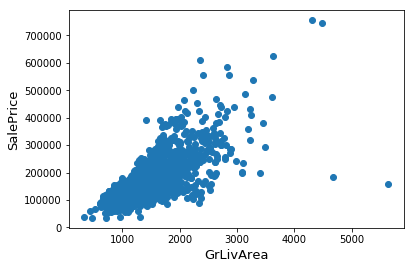

In [6]:
fig = plt.figure()
plt.scatter(x = train['GrLivArea'], y = y_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

From the above plot, we can see that there are 2 outliers that have a very low "SalePrice" despite having a huge "GrLivArea". We can safely remove them as they're huge deviation from the trend are just noise in the data.

### Target Variable Analysis:

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



 mu = 180921.20 and sigma = 79415.29



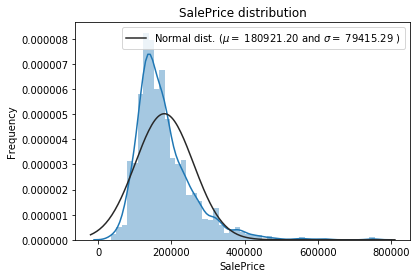

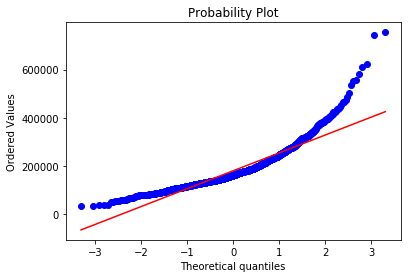

In [7]:
sns.distplot(y_train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y_train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y_train['SalePrice'], plot=plt)
plt.show()

The target variable is right skewed.  As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed.

 **Log-transformation of the target variable**

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  



 mu = 12.02 and sigma = 0.40



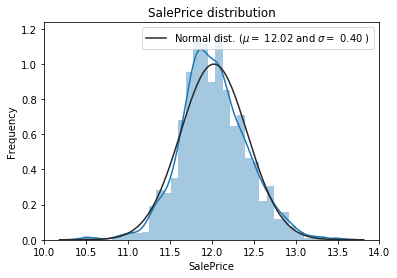

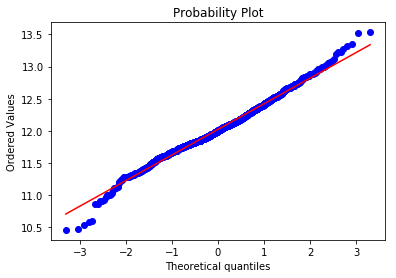

In [8]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
y_train["SalePrice"] = np.log1p(y_train["SalePrice"])

#Check the new distribution 
sns.distplot(y_train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y_train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y_train['SalePrice'], plot=plt)
plt.show()


The skew seems now corrected and the data appears more normally distributed. 

### Feature Engineering:

As we can see there are many categorical features and features with missing values, we have to handle them before we start working on the models. In order to handle the train data and test data in a similar way, we can combine them and do the feature engineering part and then seperate them before modelling.

In [9]:
ntrain = train.shape[0]
ntest = test.shape[0]
all_data = pd.concat([train, test], axis = 0, ignore_index= True)
all_ID = all_data['Id']
all_data.drop('Id', axis = 1, inplace = True)

Feature Engineering inspired from: https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

In [10]:
missingRatio = (all_data.isnull().sum()/len(all_data)*100).sort_values(ascending = False)
missingRatio.head(20)

PoolQC          99.657417
MiscFeature     96.402878
Alley           93.216855
Fence           80.438506
FireplaceQu     48.646797
LotFrontage     16.649538
GarageCond       5.447071
GarageQual       5.447071
GarageYrBlt      5.447071
GarageFinish     5.447071
GarageType       5.378554
BsmtCond         2.809181
BsmtExposure     2.809181
BsmtQual         2.774923
BsmtFinType2     2.740665
BsmtFinType1     2.706406
MasVnrType       0.822199
MasVnrArea       0.787941
MSZoning         0.137033
BsmtHalfBath     0.068517
dtype: float64

We can also see that there are features with NaN values in them. We cannot delete those samples from our data as there are certain features like "PoolQC" which only have 7 non-NaN values but can significantly impact the target variable 'SalePrice'. We can either fill the NaN valued fields with a new category for that feature, say "None", or follow one of the multiple available options to fill the NaN values by mean, median, highest, mode or zeros based on the feature individually.

From the data, we can also see that there are a lot of numerical features that should actually be categorical and not numerical. For example, "month of sale" which is currently numerical, but should be categorical as selling in January or December cannot be compared numerically. We'll have to address them as well.

### Dealing with the features with Missing values:

Let's first inspect the data to identify the features with missing values and their missing ratios, so that we can decide whether we should remove them from our dataset or to fill them with some value and use them.

**PoolQC** : data description says NA means "No  Pool". That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general. 

**MiscFeature** : data description says NA means "no misc feature"

**Alley** : data description says NA means "no alley access"

**Fence** : data description says NA means "no fence"

**FireplaceQu** : data description says NA means "no fireplace"

**LotFrontage** : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can **fill in missing values by the median LotFrontage of the neighborhood Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood

**GarageType, GarageFinish, GarageQual and GarageCond** : Replacing missing data with None

**GarageYrBlt, GarageArea and GarageCars** : Replacing missing data with 0 (Since No garage = no cars in such garage.)

**BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath** : missing values are likely zero for having no basement

**BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2** : For all these categorical basement-related features, NaN means that there is no  basement.

**MasVnrArea and MasVnrType** : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type. 

**MSZoning (The general zoning classification)** :  'RL' is by far  the most common value.  So we can fill in missing values with 'RL'

**Utilities** : For this categorical feature all records are "AllPub", except for one "NoSeWa"  and 2 NA . Since the house with 'NoSewa' is in the training set, `this feature won't help in predictive modelling`. We can then safely  remove it.

**Functional** : data description says NA means typical

**Electrical** : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.

**KitchenQual**: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent)  for the missing value in KitchenQual.

**Exterior1st and Exterior2nd** : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string

**SaleType** : Fill in again with most frequent which is "WD"

**MSSubClass** : Na most likely means No building class. We can replace missing values with None

In [11]:
#cols = train_clean[missingRatio[(missingRatio<=15) & (missingRatio >0)].index]
cols = all_data[missingRatio[missingRatio >0].index]
for col in cols:
    if col in ('Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'MasVnrType', 'MiscFeature', 'PoolQC'):
        all_data[col] = all_data[col].fillna("None")
    elif col == 'LotFrontage':
        all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    elif col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea'):
        all_data[col] = all_data[col].fillna(0)
    elif col in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'MSSubClass'):
        all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
    elif col == 'Utilities':
        all_data = all_data.drop(['Utilities'], axis=1)
    elif col == 'Functional':
        all_data["Functional"] = all_data["Functional"].fillna("Typ")
    else:
        all_data[col].fillna(0, inplace=True)

Checking for missing values, if we've missed any

In [12]:
missingRatio = (all_data.isnull().sum()/len(all_data)*100).sort_values(ascending = False)
missingRatio[missingRatio != 0]

Series([], dtype: float64)

#### Label Encoding some ordinal categorical variables:

In [13]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2919, 78)


### Transforming some numerical variables that are really categorical

In [14]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

Adding an important feature that wasn't defined in the earlier given data:

In [15]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

### Handling the skewness in the features:

In [16]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.947195
PoolArea,16.898328
LotArea,12.822431
LowQualFinSF,12.088761
3SsnPorch,11.376065
LandSlope,4.975157
KitchenAbvGr,4.302254
BsmtFinSF2,4.146143
EnclosedPorch,4.003891
ScreenPorch,3.946694


#### Box Cox Transformation of (highly) skewed features

In [17]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 55 skewed numerical features to Box Cox transform


In [18]:
all_data.shape

(2919, 79)

Therefore, the data now has no missing values. Let's proceed to encoding the categorical features.

### Encoding all categorical Features

In [19]:
all_data = pd.get_dummies(all_data)

In [20]:
all_data.head()

,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,5.831328,19.212182,0.730463,0.730463,1.540963,0.0,2.440268,14.187527,14.187527,8.059126,...,0,0,0,1,0,0,0,0,1,0
1,6.221214,19.712205,0.730463,0.730463,1.540963,0.0,2.259674,14.145138,14.145138,0.000000,...,0,0,0,1,0,0,0,0,1,0
2,5.914940,20.347241,0.730463,0.730463,0.000000,0.0,2.440268,14.184404,14.185966,7.646538,...,0,0,0,1,0,0,0,0,1,0
3,5.684507,19.691553,0.730463,0.730463,0.000000,0.0,2.440268,14.047529,14.135652,0.000000,...,0,0,0,1,1,0,0,0,0,0
4,6.314735,21.325160,0.730463,0.730463,0.000000,0.0,2.602594,14.182841,14.182841,9.391827,...,0,0,0,1,0,0,0,0,1,0


In [21]:
train = all_data[:ntrain]
test = all_data[ntrain:]
print("Train:", train.shape)
print("Test:",test.shape)

Train: (1460, 259)
Test: (1459, 259)


In [23]:
train = pd.concat([all_ID[:ntrain], all_data[:ntrain]], axis = 1)
test = pd.concat([all_ID[ntrain:], all_data[ntrain:]], axis = 1)
print("Train:", train.shape)
print("Test:",test.shape)

Train: (1460, 260)
Test: (1459, 260)


In [26]:
train.to_csv('data/train_cleaned.csv', index = False)
y_train.to_csv('data/y_train.csv', index = False)
test.to_csv('data/test_cleaned.csv', index = False)